In [2]:
from prepare import calc_rmse
import prepare
import acquire


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt

# hypothesis testing
from scipy import stats

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px

In [3]:
df = acquire.get_zillow_2017()
df = prepare.prepare_zillow(df)

In [4]:
train, X_train, y_train, X_val, y_val, X_test, y_test = prepare.split_data(df,'value')

In [5]:
# Loop through X sets and apply new_features function
X_sets = [X_train,X_val,X_test]
for x in X_sets:
    x = prepare.new_features(x)

In [6]:
train.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27495, 7),
 (27495, 9),
 (27495, 1),
 (11784, 9),
 (11784, 1),
 (9820, 9),
 (9820, 1))

### Four Questions:  
1. Are newer houses worth more?
2. Does increasing the amount of beds and baths per squarefeet change the value?
3. Does increasing lot size increase value?
4. Does the percentage of house sq ft per lot sq ft change the value?

# Are newer houses worth more?  
Continuous vs continous = pearson R, scatter

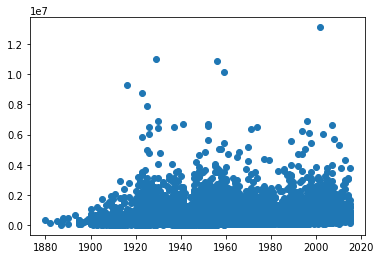

In [7]:
#px.scatter(train.yearbuilt,train.value)
plt.scatter(train.yearbuilt,train.value)


In [8]:
corr, p = stats.pearsonr(train.yearbuilt, train.value)
corr, p

(0.15259505689885328, 6.925337850756379e-143)

### It's hard to see correlation in the scatter plot but using pearsonsr confirms a relationship

# Does increasing the amount of beds and baths per squarefeet change the value?

In [9]:
train['bb_sqft'] = (train['bed']+train['bath'])/train['squarefeet']

In [10]:
train.head()

,bed,bath,squarefeet,lotsquarefeet,value,yearbuilt,fips,bb_sqft
10706,3.0,2.0,1181.0,5496.0,432736.0,1949.0,6037.0,0.004234
27627,3.0,2.0,1947.0,10000.0,410771.0,1982.0,6059.0,0.002568
25307,4.0,3.0,2281.0,5254.0,882500.0,1944.0,6037.0,0.003069
9519,3.0,1.0,1014.0,5731.0,348929.0,1950.0,6059.0,0.003945
6487,3.0,2.0,1701.0,49354.0,209051.0,1976.0,6037.0,0.002939


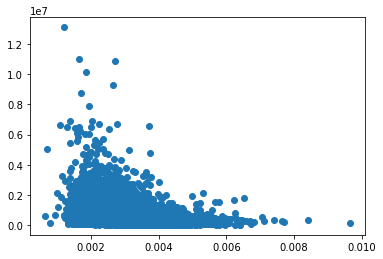

In [11]:
plt.scatter(train.bb_sqft,train.value)

In [12]:
corr, p = stats.pearsonr(train.bb_sqft, train.value)
corr, p

(-0.3488306419102324, 0.0)

### The plot looks like there might be a negative correlation between bb/sqft and value. Pearson R confirms this is the case

# Does increasing lot size increase value?

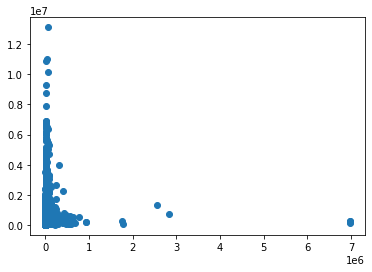

In [13]:
plt.scatter(train.lotsquarefeet,train.value)

In [14]:
alpha = .05
corr, p = stats.pearsonr(train.lotsquarefeet, train.value)
print(f'alpha: {alpha}')
print(f'p: {p/2}')
print('corr is positive and p<alpha so we can say that greater lotsquarefeet increases the value')



alpha: 0.05
p: 0.017784055224701837
corr is positive and p<alpha so we can say that greater lotsquarefeet increases the value


# Does the percentage of house sq ft per lot sq ft change the value?

In [15]:
train['hsf_lsf'] = train.squarefeet/train.lotsquarefeet

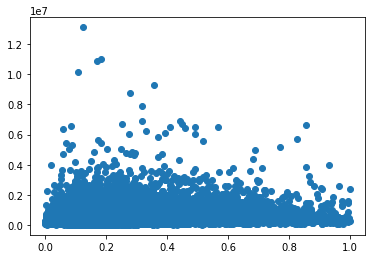

In [16]:
plt.scatter(train.hsf_lsf,train.value)

In [17]:
alpha = .05
corr, p = stats.pearsonr(train.hsf_lsf, train.value)
corr,p

(0.1967395748971063, 5.22842911744311e-238)

Houses that occupy a larger percentage of the lot size are worth more than when lot size is larger and house size smaller

1. Are newer houses worth more?
2. Does increasing the amount of beds and baths per squarefeet change the value?
3. Does increasing lot size increase value?
4. Does the percentage of house sq ft per lot sq ft change the value?

### Summary: All four features are drivers of value  
House Age - beds&baths/sqft - lot size - housesqft to lotsqft

# Let's run some models!

### First let's scale our X_sets

In [18]:
train, validate, test = prepare.scale_minmax(X_train,X_val,X_test)
    

In [19]:
# Establish baseline predictions 
y_train['base_mean'] = round(y_train.value.mean(),1)
y_train['base_median'] = round(y_train.value.median(),1)

# Evaluate baseline models using RMSE - we will use Mean as the baseline
rmse_train_mean = calc_rmse(y_train.value,y_train.base_mean)
rmse_train_median = calc_rmse(y_train.value, y_train.base_median)

# Evaluate baseline on validate test
y_val['baseline'] = round(y_train.value.mean(),1)
baseline_val = calc_rmse(y_val.value,y_val.baseline)

print('RMSE Mean: '),print(rmse_train_mean)
print('\n')
print('RMSE Median: '),print(rmse_train_median)

# Create a dict to store rmse values from our models
mod = ['baseline']
rmse = [rmse_train_mean]
rmse_val = [baseline_val]

RMSE Mean: 
482893.9318518764


RMSE Median: 
493612.56497117813


In [20]:
# Transform our X_train and X_val set into polynomials of range 1-3
pf1 = PolynomialFeatures(degree=1)
X_train_pf1 = pf1.fit_transform(X_train)
X_val_pf1 = pf1.fit_transform(X_val)

pf2 = PolynomialFeatures(degree=2)
X_train_pf2 = pf2.fit_transform(X_train)
X_val_pf2 = pf2.fit_transform(X_val)

pf3 = PolynomialFeatures(degree=3)
X_train_pf3 = pf3.fit_transform(X_train)
X_val_pf3 = pf3.fit_transform(X_val)
X_test_pf3 = pf3.fit_transform(X_test)

In [32]:
def model(ml_model,mod_name,X_train,X_val):
    '''
    ml_model: ml model
    mod_name: name of the model
    X_train: X dataset
    X_val: X dataset
    '''
    model = ml_model
    model.fit(X_train,y_train.value)
    pred = model.predict(X_train).round(1)
    rmse_train =calc_rmse(y_train.value,pred)
    pred = model.predict(X_val).round(1)
    rmse_validate = calc_rmse(y_val.value,pred)
    
    return rmse_train,rmse_validate, mod_name

In [33]:
def model_test(ml_model,mod_name,X_test):
    model = ml_model
    model.fit(X_train,y_train.value)
    pred = model.predict(X_test).round(1)
    rmse_test =calc_rmse(y_test.value,pred)
    
    return rmse_test

In [27]:
# Create all of our models
models= [LinearRegression(),LassoLars(alpha=.1),TweedieRegressor(power=0),TweedieRegressor(power=1)]
mod_name = ['lm','lass','tweedie0','tweedie1']
add_pf = ['_pf1','_pf2','_pf3']

for m,n in zip(models,mod_name): #Creates models off our reg X_train/val sets
    a,b,c = model(m,n,X_train,X_val)
    mod.append(c) # Append values to our lists
    rmse.append(a)
    rmse_val.append(b)

pfx = [X_train_pf1,X_train_pf2,X_train_pf3] #Creates models off of our pf1/pf2/pf3 X sets
pfy = [X_val_pf1,X_val_pf2,X_val_pf3]


for x,y,na in zip(pfx,pfy,add_pf):
    for m,n in zip(models,mod_name):
        name = n+na
        a,b,c = model(m,name,x,y) # Call our function
        mod.append(c) # Append values to our lists
        rmse.append(a)
        rmse_val.append(b)
        
        
results = pd.DataFrame({'model':mod,'rmse_train':rmse,'rmse_val':rmse_val}) # Create df out of lists

In [35]:
results.head()

,model,rmse_train,rmse_val
0,baseline,482893.931852,555441.062680
1,lm,395919.596809,462420.829034
2,lass,395919.613439,462428.800761
3,tweedie0,479646.502984,552505.891542
4,tweedie1,403715.542158,439255.881210


In [30]:
results.sort_values('rmse_val').head()

,model,rmse_train,rmse_val
4,tweedie1,403715.542158,439255.881210
8,tweedie1_pf1,403713.974228,439256.609379
16,tweedie1_pf3,387124.467021,444093.628089
12,tweedie1_pf2,388216.926423,446743.412725
14,lass_pf3,390392.811754,451309.746400


### We run our best model on the test set and receive a RMSE of 378565.84  
Baseline: 555441.06   Model: 378565.84  Improvement: 176875.22 = 32%

In [34]:
model_test(TweedieRegressor(power=1),'tweedie1',X_test)

378565.8444928013